# Mixed Layer Budgets 2

Here we're looking at mixed layer budgets constructed multiple ways

***

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt, dates
from cartopy import crs, feature
from datetime import datetime
from calendar import monthrange
from scipy.interpolate import interp1d
from tqdm import tqdm

plt.rcParams.update({'font.size': 14, 'axes.titlesize': 'medium'})

***

## Budget constructions

### Budget 1: Volume integrated salinity

This budget assigns outsized weight to the entrainment term, since changes in mixed layer volume outweigh changes in mixed layer salinity.

$$\boxed{\vphantom{\rule{0pt}{22pt}}\hspace{12pt}\underbrace{\frac{d}{dt}\int_VSdV}_{\textbf{Residual}} = -\underbrace{\int_{sides}\left(\vec{\mathbf{v}}_HS + \overline{\vec{\mathbf{v}}_H'S'}\right)\cdot\hat{\mathbf{n}}_HdA}_{\textbf{Horz Adv+Diff Sides}} - \underbrace{\int_{bot}\left(\vec{\mathbf{v}}_HS + \overline{\vec{\mathbf{v}}_H'S'}\right)\cdot\nabla zdA}_{\textbf{Horz Adv+Diff Bottom}} + \underbrace{\int_{bot}S(w - w_r)dA}_{\textbf{Vert Adv+Ent Bottom}} + \underbrace{\int_{bot}\overline{w'S'}dA}_{\textbf{Vert Diff Bottom}} - \underbrace{\int_{top}\overline{w'S'}dA}_{\textbf{Surface}}\hspace{12pt}}$$

### Budget 2: Mixed layer averaged salinity (flux divergence)

This budget removes the volume dependence, which redistributes dominance to advection, diffusion, and surface fluxes. Here $\overline{S}=\frac{1}{h}\int_{-h}^0Sdz$, so no bulk assumption is required.

$$\boxed{\vphantom{\rule{0pt}{22pt}}\hspace{12pt}\frac{1}{A}\int_A\left[\underbrace{\frac{d\overline{S}}{dt}}_{\textbf{Residual}} - \underbrace{\frac{\overline{S}-S}{h}w_r}_{\textbf{Entrainment}} + \underbrace{\frac{1}{h}\int_{-h}^0\nabla\cdot(\vec{\mathbf{v}}S)dz}_{\textbf{Advection}} + \underbrace{\frac{1}{h}\int_{-h}^0\nabla\cdot\left(\overline{\vec{\mathbf{v}}'S'}\right)dz}_{\textbf{Diffusion}}\right]dA = 0\hspace{12pt}}$$

### Budget 3: Mixed layer averaged salinity (boundary advection)

This budget is an interation on **Budget 2** that uses boundary advection instead of flux divergence. This allows us to also show the mean advection $\overline{\vec{\mathbf{v}}}\hspace{2pt}\overline{S}$ in addition to the FCT advection given by the tendency variables. This decomposition is clearly not accurate enough to constrain eddy statistics, but we could at least describe the residual as the combination of eddy motions AND numerical *stuff*.

$$\boxed{\vphantom{\rule{0pt}{22pt}}\hspace{12pt}\frac{1}{V}\int_A\left[\underbrace{h\frac{d\overline{S}}{dt}}_{\textbf{Residual}} - \underbrace{\left(\overline{S}-S\right)w_r}_{\textbf{Entrainment}} + \underbrace{\bigg.wS\bigg|_{-h}^0}_{\textbf{Vert Adv}} + \underbrace{\int_{-h}^0\nabla\cdot\left(\overline{\vec{\mathbf{v}}'S'}\right)dz}_{\textbf{Diffusion}}\right]dA + \frac{1}{V}\underbrace{\int_{sides}\left(\vec{\mathbf{v}}_HS\right)\cdot\hat{\mathbf{n}}_Hds}_{\textbf{Horz Adv}} = 0\hspace{12pt}}$$

***

In [2]:
def interp(Y, X, Xi, maxLevel):
    """Interpolation wrapper
    """

    # Interpolate
    Yi = []
    for y, x, xi, maxlevel in zip(Y, X, Xi, maxLevel):
        valid = np.isfinite(x)
        try:
            yi = interp1d(x[valid], y[valid])(xi)
        except ValueError:
            yi = y[maxlevel]
        Yi.append(yi)
    
    return np.array(Yi)


def get_ML_avg(array, H, mask):
    """
    """

    H_masked = H * mask
    array_avg = np.nansum(array * H_masked, axis=1) / np.nansum(H_masked, axis=1)

    return array_avg


def get_area_avg(array, areaCell):
    """
    """
    
    array_avg = (array * areaCell).sum() / areaCell.sum()

    return array_avg

In [3]:
# Init coords
coordinates = {}

In [34]:
# Build results prefix
paths = {
    'LR': {
        'mesh': '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc',
        'mask': '/pscratch/sd/b/bmoorema/maskfiles/EC30to60E2r2_transformationbudgetmasks20240724.nc',
        'results': '/pscratch/sd/b/bmoorema/run_001_062/20210421_sim7_CORE_60to30E2r2.mpaso.hist.am',
    },
    'HR': {
        'mesh': '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/oRRS18to6v3/oRRS18to6v3.171116.nc',
        'mask': '/pscratch/sd/b/bmoorema/maskfiles/oRRS18to6v3_transformationbudgetmasks20240724.nc',
        'results': '/global/cfs/cdirs/m4259/lvroekel/run_001_010/20210421_sim7_CORE_18to6v3.mpaso.hist.am',
    }
}

meshName = 'HR'

# Load mask
ds = xr.open_dataset(paths[meshName]['mask'])
idx = ds.regionNames.astype(str) == 'Labrador Sea'
regionMask, = np.where(ds.regionCellMasks[:, idx][:, 0].values.astype(bool))

# Load mesh
ds = xr.open_dataset(paths[meshName]['mesh'])
maxLevel = ds.maxLevelCell.values[regionMask] - 1
areaCell = ds.areaCell.values[regionMask]

# Package into coords dict
coordinates[meshName] = {
    'regionMask': regionMask,
    'areaCell'  : areaCell,
    'maxLevel'  : maxLevel,
}

# Variable names
prefix = 'timeMonthly_avg_'
varNames = {
    'MLD'      : 'dThreshMLD',
    'H'        : 'layerThickness',
    'S'        : 'activeTracers_salinity',
    'HorzAdv'  : 'activeTracerHorizontalAdvectionTendency_salinityHorizontalAdvectionTendency',
    'HorzMix'  : 'activeTracerHorMixTendency_salinityHorMixTendency',
    'VertAdv'  : 'activeTracerVerticalAdvectionTendency_salinityVerticalAdvectionTendency',
    'VertMix'  : 'activeTracerVertMixTendency_salinityVertMixTendency',
    'NonLocal' : 'activeTracerNonLocalTendency_salinityNonLocalTendency',
    'Surface'  : 'activeTracerSurfaceFluxTendency_salinitySurfaceFluxTendency',
}

In [11]:
outputs = {}

In [ ]:
meshName = 'HR'
coords = coordinates[meshName]

names = list(varNames.keys())[2:] + ['Entrainment']
outputs[meshName] = {name: [] for name in names}

for year in range(1, 11):
    for month in tqdm(range(1, 13), desc=f'Loading {year}'):

        variables = {}

        # Get entrainment velocity
        ds = xr.open_dataset(f"{paths[meshName]['results']}.highFrequencyOutput.{year:04d}-{month:02d}-01_00.00.00.nc")
        MLD = ds.dThreshMLD.values[:, regionMask]
        w_r = -np.mean(np.diff(MLD, axis=0), axis=0) / 432000
        
        # Get remaining variables
        ds = xr.open_dataset(f"{paths[meshName]['results']}.timeSeriesStatsMonthly.{year:04d}-{month:02d}-01.nc")
        for name, fullname in varNames.items():
            variables[name] = ds[prefix + fullname][0, ...].values[regionMask]
        variables['H'][variables['H'] == 0] = np.nan
        variables['S'][variables['S'] < -100] = np.nan
        
        # Calculate depths
        zeros = np.zeros((len(coords['regionMask']), 1))
        interface = np.hstack([zeros, np.cumsum(variables['H'], axis=1)])
        midpoint = (interface[:, :-1] + interface[:, 1:]) / 2
        
        # Get mask
        mask = (variables['MLD'][:, None] - interface[:, :-1]) / variables['H']
        mask = np.clip(mask, 0, 1)
        
        # Interpolate S to MLD
        S_bot = interp(variables['S'], midpoint, variables['MLD'], coords['maxLevel'])
        
        # Get S_avg
        variables['S'] = get_ML_avg(variables['S'], variables['H'], mask)
        
        # Calculate outputs
        for name in outputs[meshName]:
            if name == 'S':
                variable = variables[name]
            elif name == 'Entrainment':
                variable = (variables['S'] - S_bot) / variables['MLD'] * w_r * 86400
            else:
                variable = get_ML_avg(variables[name], variables['H'], mask) * 86400
            outputs[meshName][name].append(get_area_avg(variable, coords['areaCell']))

# Concatenate
for name in outputs[meshName]:
    outputs[meshName][name] = np.array(outputs[meshName][name])

In [19]:
# Get time stuff
names = list(outputs[meshName].keys())[1:]
startyear = 1948
time = np.array([datetime(year+startyear, month, 15) for year in range(10) for month in range(1, 13)])
seconds = np.array([(dt - datetime(startyear, 1, 1)).total_seconds() for dt in time])
outputs[meshName]['dSdt'] = np.gradient(outputs[meshName]['S'], seconds) * 86400
outputs[meshName]['Residual'] = sum([outputs[meshName][name] for name in names])

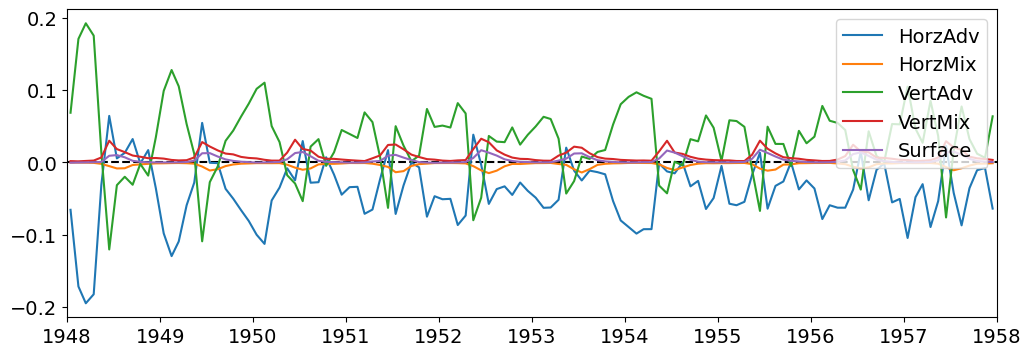

In [20]:
names = ['HorzAdv', 'HorzMix', 'VertAdv', 'VertMix', 'Surface']
xlim = [datetime(startyear, 1, 1), datetime(startyear+10, 1, 1)]
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(xlim, [0, 0], 'k--')
ax.set_xlim(xlim)
for name in names:
    ax.plot(time, outputs[meshName][name], label=name)
ax.legend(loc=1)

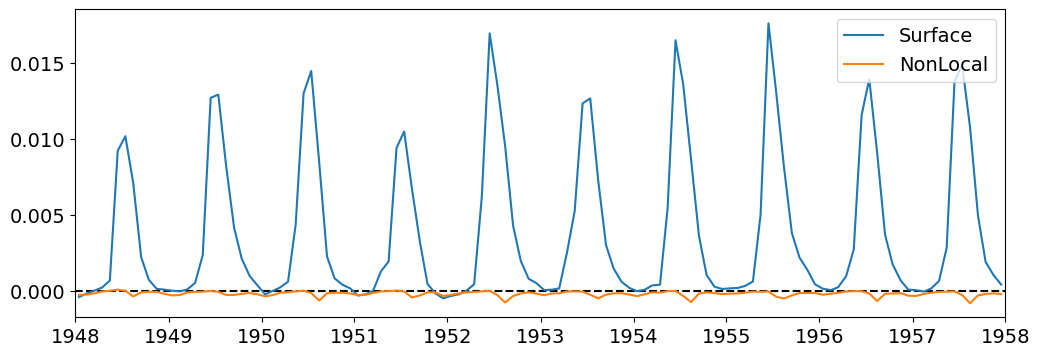

In [21]:
names = ['Surface', 'NonLocal']
xlim = [datetime(startyear, 1, 1), datetime(startyear+10, 1, 1)]
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(xlim, [0, 0], 'k--')
ax.set_xlim(xlim)
for name in names:
    ax.plot(time, outputs[meshName][name], label=name)
ax.legend(loc=1)

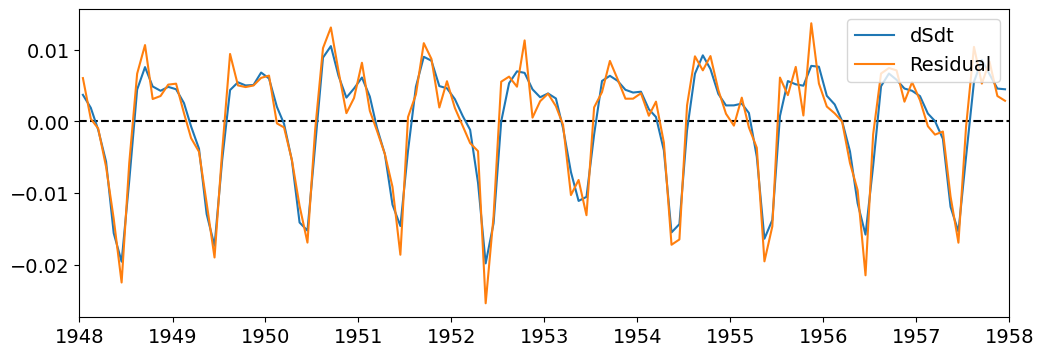

In [30]:
names = ['dSdt', 'Residual']
xlim = [datetime(startyear, 1, 1), datetime(startyear+10, 1, 1)]
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(xlim, [0, 0], 'k--')
ax.set_xlim(xlim)
for name in names:
    ax.plot(time, outputs[meshName][name], label=name)
ax.legend(loc=1)

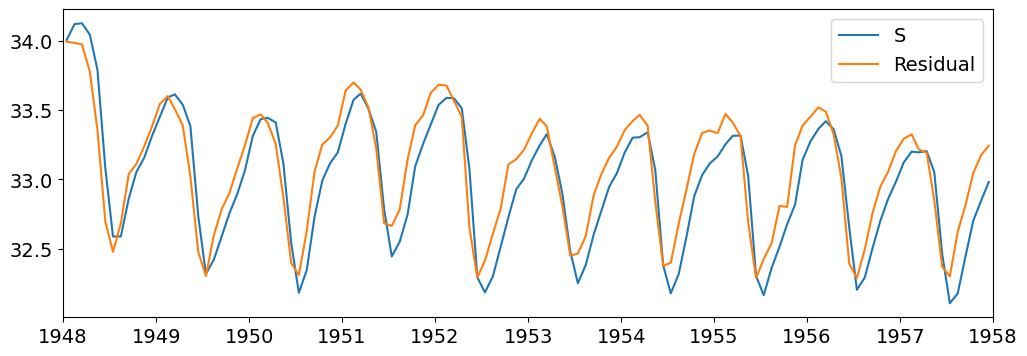

In [33]:
days = np.array([monthrange(2010, month)[1] for year in range(10) for month in range(1, 13)])
xlim = [datetime(startyear, 1, 1), datetime(startyear+10, 1, 1)]
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_xlim(xlim)
ax.plot(time, outputs[meshName]['S'], label='S')
S_res = np.cumsum(outputs[meshName]['Residual'])*days + outputs[meshName]['S'][0] - 0.2
ax.plot(time, S_res, label='Residual')
ax.legend(loc=1)